# Oanda Demo Trading Notebook

## Packages

### Normal Packages

In [1]:
import numpy as np
import pandas as pd


import yaml
import json

import sys
import time
import math
import pytz
import datetime
import winsound
import collections
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

from tqdm import tqdm
import pylab as pl
from IPython import display

import warnings
warnings.filterwarnings('ignore')

### Oanda Packages

In [2]:
from oandapyV20 import API
import oandapyV20.endpoints.orders as orders
import oandapyV20.endpoints.trades as trades
import oandapyV20.endpoints.pricing as pricing
import oandapyV20.endpoints.accounts as accounts
import oandapyV20.endpoints.transactions as trans
import oandapyV20.endpoints.positions as positions

import oandapyV20.definitions.pricing as defpricing

import oandapyV20.endpoints.instruments as instruments

from oandapyV20.contrib.requests import (MarketOrderRequest, StopLossDetails)

### Custom packages

In [3]:
from utils.tools import get_date_time
from utils.tools import get_prices
from utils.tools import calc_duration

## API Setup

Read from config file

In [4]:
temp_file = 'config/access_keys.yaml'
with open(temp_file) as temp_file:
    config = yaml.load(temp_file)
    
temp_file = 'config/currencies.yaml'
with open(temp_file) as temp_file:
    currencies = yaml.load(temp_file)

temp_file = 'config/stepped_loss.yaml'
with open(temp_file) as temp_file:
    loss_limits = yaml.load(temp_file)

In [5]:
access_token = config['oanda_demo_account']['token']
accountID = config['oanda_demo_account']['account_id']
api = API(access_token = access_token)

# Log these inputs as well

In [6]:
def convert_to_df(tick_list, short_wma_list, long_wma_list):
    df = pd.DataFrame({'tick_list':tick_list, 'short_wma_list':short_wma_list, 'long_wma_list':long_wma_list}, 
                      columns = ['tick_list', 'short_wma_list', 'long_wma_list'])
    return(df)

In [7]:
def get_weights(s):
    n = 1/s
    val = 0
    val_list = []
    for i in range(s):
        val += n
        val_list.append(val)
    val_list = np.array(val_list)
    tot = sum(val_list)
    val_list = val_list/tot
    return(val_list)

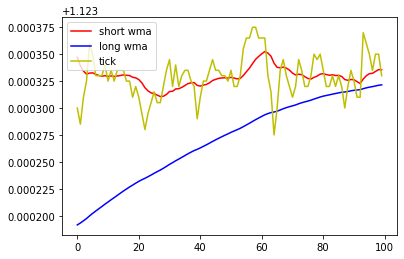

In [ ]:
instrument="EUR_USD"
short_moving_window = 20
long_moving_window = 200
lists_size = 100

params = {'instruments': instrument}
order_flag = 'not_ordered'
r = pricing.PricingStream(accountID=accountID, params=params)
rv = api.request(r)

short_wma = 0
short_flag = True
short_list = collections.deque([])
short_wma_list = collections.deque([])
short_weights = get_weights(short_moving_window)

long_wma = 0
long_flag = True
long_list = collections.deque([])
long_wma_list = collections.deque([])
long_weights = get_weights(long_moving_window)

tick_list = collections.deque([])

start_time = time.time()
time_flag = True 

for i, resp in enumerate(rv):        
    resp_type = resp['type']       

    # Heart beat response to keep the api connection alive (Avoid timeout)
    if resp_type == 'HEARTBEAT': 
        pass
    #-----------------------------------------------------------------------------------------------------
    
    
    # Price response 
    elif resp_type == 'PRICE' and order_flag == 'not_ordered': # Check if we are yet to make the order               
        
        #Decode values from response
        date_val, time_val, time_fraction = get_date_time(resp) # Get time stamp for reference            
        sell_price, buy_price, spread, tick_price = get_prices(resp) # Get prices from the response                      
        #-----------------------------------------------------------------------------------------
        
        #Prepare short list to calculate WMA of shortwindows
        if len(short_list) < short_moving_window:
            short_list.append(tick_price)

        # Calculate wma for first iteration
        if short_flag and len(short_list) == short_moving_window:
            short_wma = sum(np.array(short_list)*short_weights)
            short_flag =  False

        # Calculate wma from the second iteration
        if short_flag == False and len(short_list) == short_moving_window:
            short_list.popleft()   
            short_list.append(tick_price) 
            short_wma = sum(np.array(short_list)*short_weights)

        # Append WMA list
        if len(short_list) == short_moving_window:
            if len(short_wma_list) < lists_size:
                short_wma_list.append(short_wma)

            elif len(short_wma_list) == lists_size:
                short_wma_list.popleft()   
                short_wma_list.append(short_wma) 
                
        #print(f'short_wma_list : {len(short_wma_list)}')
        #-----------------------------------------------------------------------------------------
        
        
        #Prepare long list to calculate WMA of longwindows
        if len(long_list) < long_moving_window:
            long_list.append(tick_price)
            
         # Calculate wma for first iteration
        if long_flag and len(long_list) == long_moving_window:
            long_wma = sum(np.array(long_list)*long_weights)
            long_flag =  False

        # Calculate wma from the second iteration
        if long_flag == False and len(long_list) == long_moving_window:
            long_list.popleft()   
            long_list.append(tick_price) 
            long_wma = sum(np.array(long_list)*long_weights)

        # Append WMA list
        if len(long_list) == long_moving_window:
            if len(long_wma_list) < lists_size:
                long_wma_list.append(long_wma)
                tick_list.append(tick_price)

            # If WMA list reached required size start plotting
            elif len(long_wma_list) == lists_size:
                if time_flag:
                    end_time = time.time()    
                    duration = calc_duration(start_time, end_time)
                    time_flag = False
                plt.close()
                long_wma_list.popleft()   
                long_wma_list.append(long_wma)  
                
                tick_list.popleft()   
                tick_list.append(tick_price)                  
                
                plt.plot(short_wma_list, 'r' ,label="short wma")
                plt.plot(long_wma_list,'b' ,label="long wma")
                plt.plot(tick_list, 'y' ,label="tick")
                plt.legend(loc="upper left")
                display.display(plt.gcf())
                display.clear_output(wait = True)                

In [ ]:
duration

In [ ]:
df = convert_to_df(tick_list, short_wma_list, long_wma_list)

In [ ]:
df